In [1]:
pip install scikit-learn seaborn Pyarrow


Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install statsmodels

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import statsmodels.api as sm

In [3]:
df = pd.read_csv("transfers_uruguay (1).csv")
df

,inc_centered,educ,age,in_program,gov_support
0,0.006571,3.5,23.666666,0,1.0
1,0.011075,1.5,42.000000,0,1.0
2,0.002424,4.0,43.000000,0,1.0
3,0.007650,6.0,21.000000,0,0.5
4,0.010001,2.0,33.000000,0,1.0
...,...,...,...,...,...
1943,-0.013489,2.0,27.333334,1,1.0
1944,-0.012106,4.5,37.000000,1,1.0
1945,-0.010159,5.0,25.857143,1,1.0
1946,-0.008668,3.0,26.000000,1,1.0


/tmp/ipykernel_977/2958849612.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_df = df.groupby('income').agg(avg_income = ('inc_centered', 'mean'),avg_gov_support = ('gov_support', 'mean'))


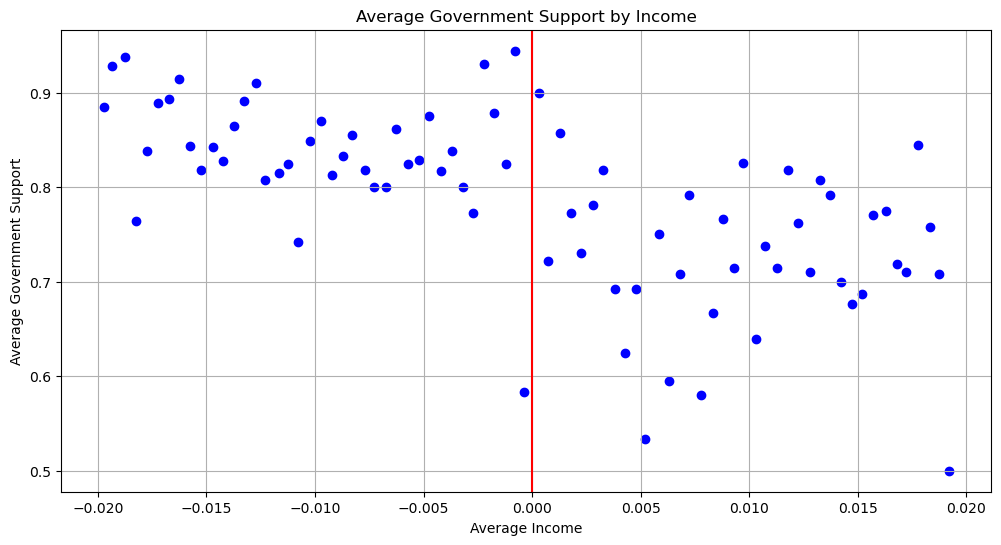

In [4]:
bins = np.arange(df['inc_centered'].min(), df['inc_centered'].max(), 0.0005)
df['income'] = pd.cut(df['inc_centered'], bins)
binned_df = df.groupby('income').agg(avg_income = ('inc_centered', 'mean'),avg_gov_support = ('gov_support', 'mean'))
plt.figure(figsize = (12, 6))
plt.scatter(binned_df['avg_income'], binned_df['avg_gov_support'], color ='blue')
plt.axvline(x = 0, color = 'red', label = 'Income Cutoff') 
plt.title('Average Government Support by Income') 
plt.xlabel('Average Income')
plt.ylabel('Average Government Support')
plt.grid(True)
plt.show()

In [5]:
below_cutoff = df[df['inc_centered'] < 0]
above_cutoff = df[df['inc_centered'] >= 0]
model_below = LinearRegression().fit(below_cutoff[['inc_centered']],below_cutoff['gov_support'])
model_above = LinearRegression().fit(above_cutoff[['inc_centered']],above_cutoff['gov_support'])
pred_below = model_below.predict([[0]])
pred_above = model_above.predict([[0]])
causal_estimate = pred_above - pred_below
print('Causal estimate:', causal_estimate)

Causal estimate: [-0.09985189]


/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [7]:
df['above_cutoff'] = (df['inc_centered'] >= 0).astype(int)
model_simple_rdd = LinearRegression()
predictors = ['inc_centered', 'above_cutoff']

model_simple_rdd.fit(df[predictors], df['gov_support'])

rdd_estimate = model_simple_rdd.coef_[1]  
print(f"The RDD estimate without using an interaction term is: {rdd_estimate}")


The RDD estimate without using an interaction term is: -0.09744515262077785


In [9]:
# Adding a constant for the intercept
X = sm.add_constant(df[['inc_centered', 'above_cutoff']])
y = df['gov_support']

# Fit the model using statsmodels for detailed statistics
model = sm.OLS(y, X).fit()

# Get the 95% confidence interval for the RDD estimate
conf_interval = model.conf_int().loc['above_cutoff']

# Print summary for detailed output including p-values and confidence intervals
model_summary = model.summary()
conf_interval_summary = f"95% Confidence Interval for the RDD estimate: {conf_interval}"

model_summary, conf_interval_summary

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:            gov_support   R-squared:                       0.034
 Model:                            OLS   Adj. R-squared:                  0.033
 Method:                 Least Squares   F-statistic:                     34.28
 Date:                Sat, 24 Aug 2024   Prob (F-statistic):           2.34e-15
 Time:                        06:53:04   Log-Likelihood:                -499.03
 No. Observations:                1948   AIC:                             1004.
 Df Residuals:                    1945   BIC:                             1021.
 Df Model:                           2                                         
 Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
 -------------------------------------------------------------------

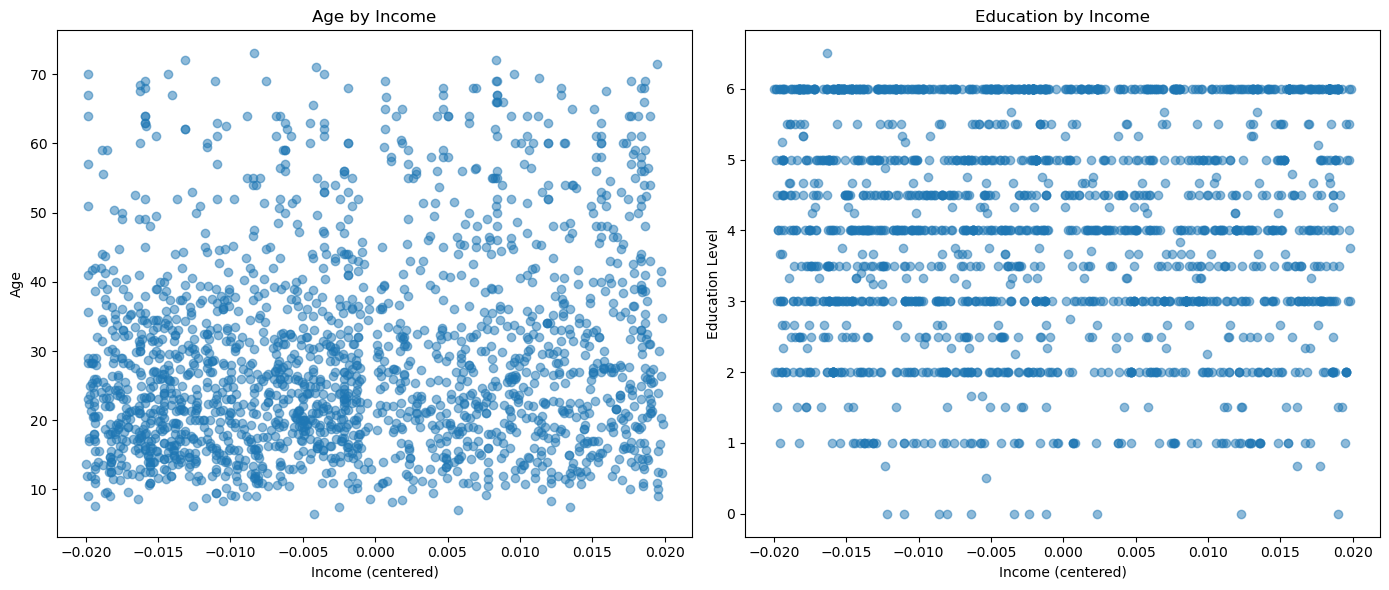

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].scatter(df['inc_centered'], df['age'], alpha=0.5)
ax[0].set_title('Age by Income')
ax[0].set_xlabel('Income (centered)')
ax[0].set_ylabel('Age')
ax[1].scatter(df['inc_centered'], df['educ'], alpha=0.5)
ax[1].set_title('Education by Income')
ax[1].set_xlabel('Income (centered)')
ax[1].set_ylabel('Education Level')

plt.tight_layout()
plt.show()

In [11]:
y_age = df['age']
model_age = sm.OLS(y_age, X).fit()

y_educ = df['educ']
model_educ = sm.OLS(y_educ, X).fit()

rdd_estimate_age = model_age.conf_int().loc['above_cutoff']
rdd_estimate_educ = model_educ.conf_int().loc['above_cutoff']

model_age_summary = model_age.summary()
model_educ_summary = model_educ.summary()

model_age_summary, rdd_estimate_age, model_educ_summary, rdd_estimate_educ

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                    age   R-squared:                       0.024
 Model:                            OLS   Adj. R-squared:                  0.023
 Method:                 Least Squares   F-statistic:                     24.34
 Date:                Sat, 24 Aug 2024   Prob (F-statistic):           3.61e-11
 Time:                        06:53:48   Log-Likelihood:                -7939.1
 No. Observations:                1948   AIC:                         1.588e+04
 Df Residuals:                    1945   BIC:                         1.590e+04
 Df Model:                           2                                         
 Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
 -------------------------------------------------------------------

RDD Estimate for Age: 1.2626
95% Confidence Interval: [-1.351, 3.876]
The result is not statistically significant (p = 0.344).

In [12]:
clean_data = df.dropna(subset=['educ'])

X_clean = sm.add_constant(clean_data[['inc_centered', 'above_cutoff']])
y_educ_clean = clean_data['educ']

# Fit the model using the cleaned data
model_educ_clean = sm.OLS(y_educ_clean, X_clean).fit()

# Get the RDD estimate and confidence interval for the cleaned data
rdd_estimate_educ_clean = model_educ_clean.conf_int().loc['above_cutoff']
model_educ_clean_summary = model_educ_clean.summary()

model_educ_clean_summary, rdd_estimate_educ_clean

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                   educ   R-squared:                       0.000
 Model:                            OLS   Adj. R-squared:                 -0.001
 Method:                 Least Squares   F-statistic:                    0.3050
 Date:                Sat, 24 Aug 2024   Prob (F-statistic):              0.737
 Time:                        06:54:24   Log-Likelihood:                -3498.6
 No. Observations:                1897   AIC:                             7003.
 Df Residuals:                    1894   BIC:                             7020.
 Df Model:                           2                                         
 Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
 -------------------------------------------------------------------

The RDD model for Age did not show a statistically significant difference at the income cutoff. The changes in age across the cutoff were small and not statistically meaningful. The lack of significant results for age suggests that the cutoff does not influence or correlate with age differences. This indicates that age is uniformly distributed across the income spectrum near the cutoff. There was no significant discontinuity at the income cutoff, suggesting no substantial change in education levels due to the cutoff. The results for Age support the validity of the RDD approach in this context, as they suggest no hidden biases related to age affecting the results